In [1]:
import tensorflow as tf
assert tf.__version__.startswith('2')

import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
tf.__version__

'2.2.0'

In [6]:
'''
_URL = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

zip_file = tf.keras.utils.get_file(origin=_URL, 
                                   fname="flower_photos.tgz", 
                                   extract=True)
'''
#base_dir = os.path.join(os.path.dirname(zip_file), 'flower_photos')
base_dir = '/home/motoko/python-projects/tool-detect/data'

In [7]:
print(base_dir)

/home/motoko/python-projects/tool-detect/data


In [8]:
IMAGE_SIZE = 224
BATCH_SIZE = 64

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, 
    validation_split=0.2)

train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='training')

val_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='validation')

Found 309 images belonging to 7 classes.
Found 74 images belonging to 7 classes.


In [9]:
for image_batch, label_batch in train_generator:
  break
image_batch.shape, label_batch.shape

((64, 224, 224, 3), (64, 7))

In [10]:
print (train_generator.class_indices)

labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(labels)

{'gewindefraeser': 0, 'messerkopf': 1, 'models': 2, 'reibahle': 3, 'schaftfraeser': 4, 'spiralbohrer': 5, 'wendeschneidplatten': 6}


In [11]:
!cat labels.txt

gewindefraeser
messerkopf
models
reibahle
schaftfraeser
spiralbohrer
wendeschneidplatten

In [12]:
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                              include_top=False, 
                                              weights='imagenet')

In [13]:
base_model.trainable = False

In [20]:
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(7, activation='softmax')
])

In [21]:
model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [22]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5, 5, 32)          368672    
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 5, 32)          0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 231       
Total params: 2,626,887
Trainable params: 368,903
Non-trainable params: 2,257,984
_________________________________________________________________


In [23]:
print('Number of trainable variables = {}'.format(len(model.trainable_variables)))

Number of trainable variables = 4


In [24]:
epochs = 10

history = model.fit(train_generator, 
                    steps_per_epoch=len(train_generator), 
                    epochs=epochs, 
                    validation_data=val_generator, 
                    validation_steps=len(val_generator))

Epoch 1/10
5/5 [==============================] - 5s 919ms/step - loss: 2.6342 - accuracy: 0.3948 - val_loss: 1.9503 - val_accuracy: 0.4054
Epoch 2/10
5/5 [==============================] - 4s 770ms/step - loss: 0.7440 - accuracy: 0.7508 - val_loss: 1.6391 - val_accuracy: 0.5405
Epoch 3/10
5/5 [==============================] - 4s 852ms/step - loss: 0.5546 - accuracy: 0.8220 - val_loss: 1.4307 - val_accuracy: 0.5676
Epoch 4/10
5/5 [==============================] - 4s 772ms/step - loss: 0.3613 - accuracy: 0.8673 - val_loss: 2.0216 - val_accuracy: 0.5541
Epoch 5/10
5/5 [==============================] - 4s 824ms/step - loss: 0.2621 - accuracy: 0.8932 - val_loss: 1.8494 - val_accuracy: 0.6081
Epoch 6/10
5/5 [==============================] - 4s 747ms/step - loss: 0.2005 - accuracy: 0.9320 - val_loss: 1.7209 - val_accuracy: 0.6351
Epoch 7/10
5/5 [==============================] - 4s 811ms/step - loss: 0.1177 - accuracy: 0.9709 - val_loss: 1.4052 - val_accuracy: 0.6622
Epoch 8/10
5/5 [====

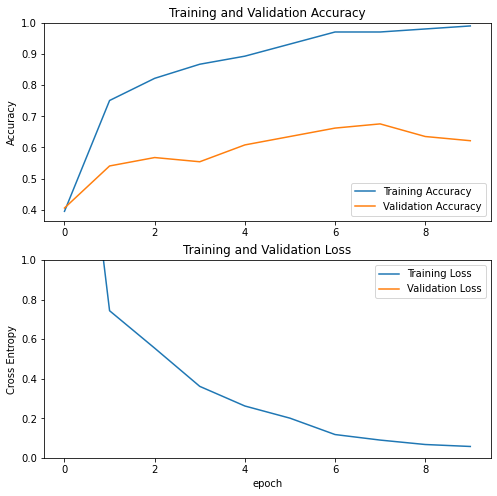

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [26]:
base_model.trainable = True

In [27]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  155


In [28]:
model.compile(loss='categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(1e-5),
              metrics=['accuracy'])

In [29]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5, 5, 32)          368672    
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 5, 32)          0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 231       
Total params: 2,626,887
Trainable params: 2,231,495
Non-trainable params: 395,392
_________________________________________________________________


In [30]:
print('Number of trainable variables = {}'.format(len(model.trainable_variables)))

Number of trainable variables = 60


In [31]:
history_fine = model.fit(train_generator, 
                         steps_per_epoch=len(train_generator), 
                         epochs=5, 
                         validation_data=val_generator, 
                         validation_steps=len(val_generator))

Epoch 1/5
5/5 [==============================] - 10s 2s/step - loss: 0.8417 - accuracy: 0.7217 - val_loss: 1.5288 - val_accuracy: 0.6622
Epoch 2/5
5/5 [==============================] - 9s 2s/step - loss: 0.6250 - accuracy: 0.7896 - val_loss: 1.4052 - val_accuracy: 0.7027
Epoch 3/5
5/5 [==============================] - 9s 2s/step - loss: 0.3287 - accuracy: 0.8641 - val_loss: 1.4586 - val_accuracy: 0.6892
Epoch 4/5
5/5 [==============================] - 7s 1s/step - loss: 0.2329 - accuracy: 0.9320 - val_loss: 1.4571 - val_accuracy: 0.7162
Epoch 5/5
5/5 [==============================] - 9s 2s/step - loss: 0.2544 - accuracy: 0.9094 - val_loss: 1.4266 - val_accuracy: 0.7027


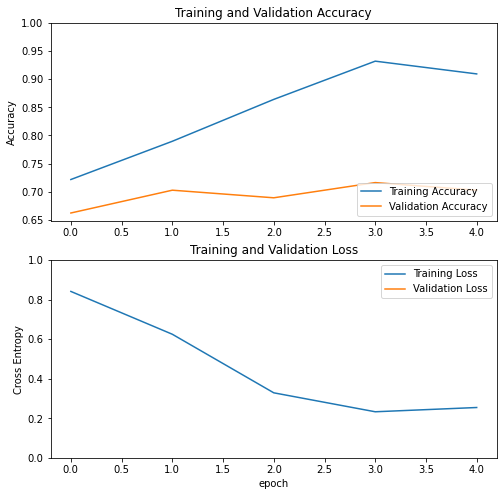

In [32]:
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [33]:
saved_model_dir = 'save/fine_tuning'
tf.saved_model.save(model, saved_model_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: save/fine_tuning/assets
